# Winery classification using the one-dimensional Gaussian

The Gaussian distribution is used to model the conditional probability of each feature given a specific label value. Bayesian inversion can be used to get the conditional probability of a label given the value of features. In this notebook, each variable is examined independently with fitting a univariate Gaussian distribution.

The data can be downloaded from the UCI repository (https://archive.ics.uci.edu/ml/datasets/wine). It contains 178 labeled data points, each corresponding to a bottle of wine:
* The features (`x`): a 13-dimensional vector consisting of visual and chemical features for the bottle of wine
* The label (`y`): the winery from which the bottle came (1,2,3)

## Load in the data set

We start by loading the packages we will need.

In [1]:
# Standard includes
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# Useful module for dealing with the Gaussian density
from scipy.stats import norm, multivariate_normal
# installing packages for interactive graphs
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider

Next, load the Wine data set. There are 178 data points, each with 13 features and a label (1,2,3).
We will divide these into a training set of 130 points and a test set of 48 points.

In [2]:
# 'wine.data.txt' needs to be in the same directory
data = np.loadtxt('wine.data.txt', delimiter=',')
# Names of features
featurenames = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols', 
                'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
                'OD280/OD315 of diluted wines', 'Proline']

Fix a particular "random" permutation of the data, and use these to effect the training / test split.
We get four arrays:
* `trainx`: 130x13, the training points
* `trainy`: 130x1, labels of the training points
* `testx`: 48x13, the test points
* `testy`: 48x1, labels of the test points

## Create train and test data sets

In [3]:
n_total = len(data)
n_features = len(featurenames)
classes = np.unique(data[:,0])
n_classes = len(np.unique(data[:,0]))
n_train = 130
n_test = 48

In [4]:
# Split 178 instances into training set (trainx, trainy) of size 130 and test set (testx, testy) of size 48
# Also split apart data and labels
np.random.seed(0)
perm = np.random.permutation(n_total)
trainx = data[perm[0:n_train],1:n_features+1]
trainy = data[perm[0:n_train],0]
testx = data[perm[n_train:], 1:n_features+1]
testy = data[perm[n_train:],0]

Check probability of each class for training data set

In [5]:
for i in range(n_classes):
    print('Total number of label {}: {} %{:.2f}'.format(i+1, sum(trainy==i+1), 100*sum(trainy==i+1)/n_train))

Total number of label 1: 43 %33.08
Total number of label 2: 54 %41.54
Total number of label 3: 33 %25.38


Check probability of each class for test data set

In [6]:
for i in range(n_classes):
    print('Total number of label {}: {} %{:.2f}'.format(i+1, sum(testy==i+1), 100*sum(testy==i+1)/n_test))

Total number of label 1: 16 %33.33
Total number of label 2: 17 %35.42
Total number of label 3: 15 %31.25


## Look at the distribution of a each feature from one of the wineries


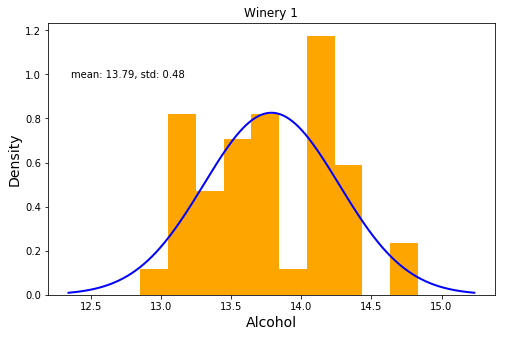

In [7]:
@interact( feature=IntSlider(1,1,13), label=IntSlider(1,1,3))
def density_plot(feature, label):
    feature = feature -1
    fig, ax = plt.subplots(1,1, figsize = (8,5))
    ax.hist(trainx[trainy==label,feature], density=True, facecolor='orange')
    #
    mu = np.mean(trainx[trainy==label,feature]) # mean
    var = np.var(trainx[trainy==label,feature]) # variance
    std = np.sqrt(var) # standard deviation
    
    # 99.7% of the data 
    x_axis = np.linspace(mu - 3*std, mu + 3*std, 1000)
    ax.plot(x_axis, norm.pdf(x_axis,mu,std), 'b', lw=2)
    ax.set_title("Winery "+str(label) )
    ax.text(x=0.05, y=0.8, s='mean: {:.2f}, std: {:.2f}'.format(mu, std), transform = ax.transAxes)
    ax.set_xlabel(featurenames[feature], fontsize=14, color='k')
    ax.set_ylabel('Density', fontsize=14, color='k')

### Identify the feature with least variability for each wine type

In [8]:
# Get the minimum variability for each class
@interact(label=IntSlider(1,1,3))
def get_min_variability(label):
    std = np.zeros(n_features)
    for feature in range(n_features):
        std[feature] = np.std(trainx[trainy==label,feature])

    print('Feature {:g} has the minimum standard deviation ({:.2f})'.format(np.argmin(std), np.min(std)))

Feature 7 has the minimum standard deviation (0.06)


## 3. Fit a Gaussian to each class

Let's define a function that will fit a Gaussian generative model to the three classes, given a single feature.

In [9]:
def fit_generative_model(x,y,feature):
    feature =feature - 1 # Index
    mu = {}
    var ={}
    pi = {}
    for label in range(n_classes):
        label+=1
        indices = (y==label)
        mu.update({label:np.mean(x[indices,feature])})
        
        var.update({label:np.var(x[indices,feature])})
        
        pi.update({label:float(sum(indices))/float(len(y))})
    return mu, var, pi

Next, display the Gaussian distribution for each of the three classes

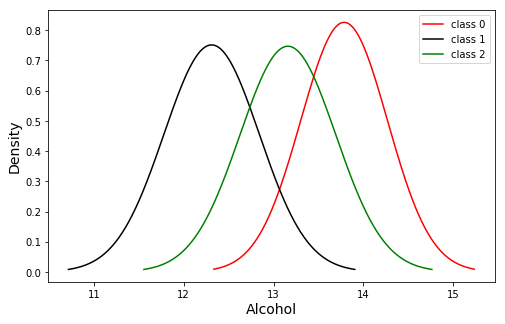

In [10]:
@interact( feature=IntSlider(1,1,13) )
def show_densities(feature):
    fig, ax = plt.subplots(1,1, figsize = (8,5))
    mu, var, pi = fit_generative_model(trainx, trainy, feature)
    
    colors = ['r', 'k', 'g']
    
    for label in range(n_classes):
        m = mu[label+1]
        s = np.sqrt(var[label+1])
        x_axis = np.linspace(m - 3*s, m+3*s, 1000)
        ax.plot(x_axis, norm.pdf(x_axis,m,s), colors[label], label="class " + str(label))
    ax.set_xlabel(featurenames[feature-1], fontsize=14, color='k')
    ax.set_ylabel('Density', fontsize=14, color='k')
    ax.legend()

The fitted Gaussian distributions/kernels can be used to evaluate the overlap between different classes for each feature. The feature with least overlap should provide a better accuracy as it results in distinction between different wine types.

## Predict labels for the test set

Using Bayesian inversion we have"

$ P(Y=y_j | X ) = \frac{P(X| Y=y_j). P(Y=y_j) }{P(X)} $

Since the denominator is the same for all the labels/wine types, we can ignore that and find the use the majority rule decision and classify the wine given the feature value (i.e. $x$). 

In [11]:
@interact( feature=IntSlider(1,1,13)  )
def test_model(feature):
    mu, var, pi = fit_generative_model(trainx, trainy, feature)

    score = np.zeros((n_test,n_classes))
    for i in range(n_test):
        for label in range(n_classes):
            # Using log probaility and summation instead of multiplocation
            score[i,label] = np.log(pi[label+1]) + \
            norm.logpdf(testx[i,feature-1], mu[label+1], np.sqrt(var[label+1])) 
    predictions = np.argmax(score, axis=1) + 1
    # Finally, tally up score
    errors = np.sum(predictions != testy)
    print ("Test error using feature " + featurenames[feature-1] + ": " + str(errors) + "/" + str(n_test))

Test error using feature Alcohol: 17/48
